In [ ]:
#!pip install --upgrade --no-cache-dir gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_clean_preprocessed'
output_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram_2'

In [ ]:
#!du -sh /content/drive/MyDrive/ADV_ML/OGLE3_clean_preprocessed


In [ ]:
#!du -sh /content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio.transforms as transforms
import random
import shutil
from tqdm import tqdm

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)

torch.Size([500, 2])
torch.Size([2, 500])
torch.Size([2, 64, 56])


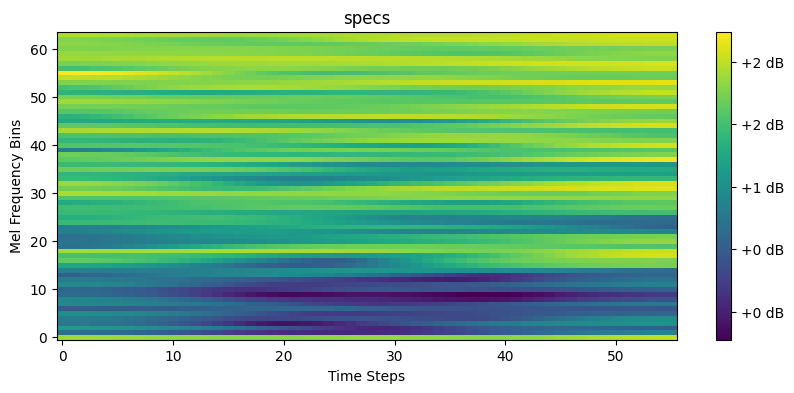

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ADV_ML/OGLE3_clean_preprocessed/wd_preprocessed/OGLE-GD-WD-0001_preprocessed.csv')

signal = torch.tensor(data[['mag_diff', 'time_diff']].values, dtype=torch.float32)
print(signal.shape)
signal = torch.transpose(signal,0,1)
print(signal.shape)





# Extract spectrogra
spectrogram_transform = transforms.MelSpectrogram(sample_rate=8000, n_mels=64)

sample_rate = 8000
n_fft = 512  # Reducing the FFT size can help capture shorter time variations
win_length = 512  # Window size for the FFT, can be the same as n_fft
hop_length = 9 # Reducing hop length to increase the number of time steps
n_mels = 64
spectrogram_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels
)
spectrogram = spectrogram_transform(signal)
print(spectrogram.shape)
plot_spectrogram(spectrogram[1],"specs")

##preprocessing

In [ ]:
def extract_spectrograms(root_folder, output_folder):
    """
    Extract spectrograms for each CSV file in class folders within the root directory.

    Args:
    - root_folder (str): Path to the root directory containing class folders with CSV files.
    - output_folder (str): Path to the directory where spectrograms will be stored.
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over each class folder in the root directory
    for class_folder in os.listdir(root_folder):
        class_folder_path = os.path.join(root_folder, class_folder)

        # Only process directories
        if os.path.isdir(class_folder_path):
            # Create a new directory for the class within the specified output folder
            class_output_folder = os.path.join(output_folder, class_folder)
            if not os.path.exists(class_output_folder):
                os.makedirs(class_output_folder)

            # Iterate over CSV files in the class folder
            for csv_file in tqdm(os.listdir(class_folder_path), desc=f"Processing {class_folder.split('_')[0]}"):
                if csv_file.endswith('.csv'):
                    csv_file_path = os.path.join(class_folder_path, csv_file)

                    # Load CSV file
                    df = pd.read_csv(csv_file_path)

                    # Concatenate time_diff and mag_diff columns into a single tensor
                    signal = torch.tensor(df[['mag_diff', 'time_diff']].values, dtype=torch.float32)
                    signal = torch.transpose(signal,0,1)


                    # Extract spectrogram
                    sample_rate = 8000
                    n_fft = 512  # Reducing the FFT size can help capture shorter time variations
                    win_length = 512  # Window size for the FFT, can be the same as n_fft
                    hop_length = 9 # Reducing hop length to increase the number of time steps
                    n_mels = 64
                    spectrogram_transform = transforms.MelSpectrogram(
                        sample_rate=sample_rate,
                        n_fft=n_fft,
                        win_length=win_length,
                        hop_length=hop_length,
                        n_mels=n_mels
                    )
                    spectrogram = spectrogram_transform(signal)

                    # Save spectrogram
                    spectrogram_file_name = os.path.splitext(csv_file)[0] + '_spectrogram.pt'
                    spectrogram_file_path = os.path.join(class_output_folder, spectrogram_file_name)
                    torch.save(spectrogram, spectrogram_file_path)

    print("\nSpectrogram extraction complete.")

In [ ]:
root_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_clean_preprocessed'
output_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram_2'

In [ ]:
extract_spectrograms(root_folder, output_folder)

Processing t2cep: 100%|██████████| 3618/3618 [07:28<00:00,  8.06it/s]


Spectrogram extraction complete.


In [ ]:
def plot_random_spectrograms(output_folder):
    """
    Plot one randomly selected spectrogram from each class folder in the output folder in a plot with two columns.

    Args:
    - output_folder (str): Path to the directory containing spectrogram subfolders.
    """
    # Get list of all spectrogram subfolders (class folders)
    class_folders = [f for f in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, f))]

    # Calculate number of rows and columns needed for subplots
    num_rows = (len(class_folders) + 1) // 2  # +1 to ensure at least 1 row if len(class_folders) is odd
    num_cols = 2

    # Create a plot with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8,24))

    # Plot one spectrogram from each class folder
    for i, class_folder in enumerate(class_folders):
        class_folder_path = os.path.join(output_folder, class_folder)
        spectrogram_files = os.listdir(class_folder_path)

        # Randomly select one spectrogram file
        random_spectrogram_file = random.choice(spectrogram_files)
        spectrogram_file_path = os.path.join(class_folder_path, random_spectrogram_file)
        spectrogram = torch.load(spectrogram_file_path)

        # Plot spectrogram in the appropriate subplot
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(spectrogram.log2()[0], aspect='auto', origin='lower')
        ax.set_title(f"Class: {class_folder}")
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()




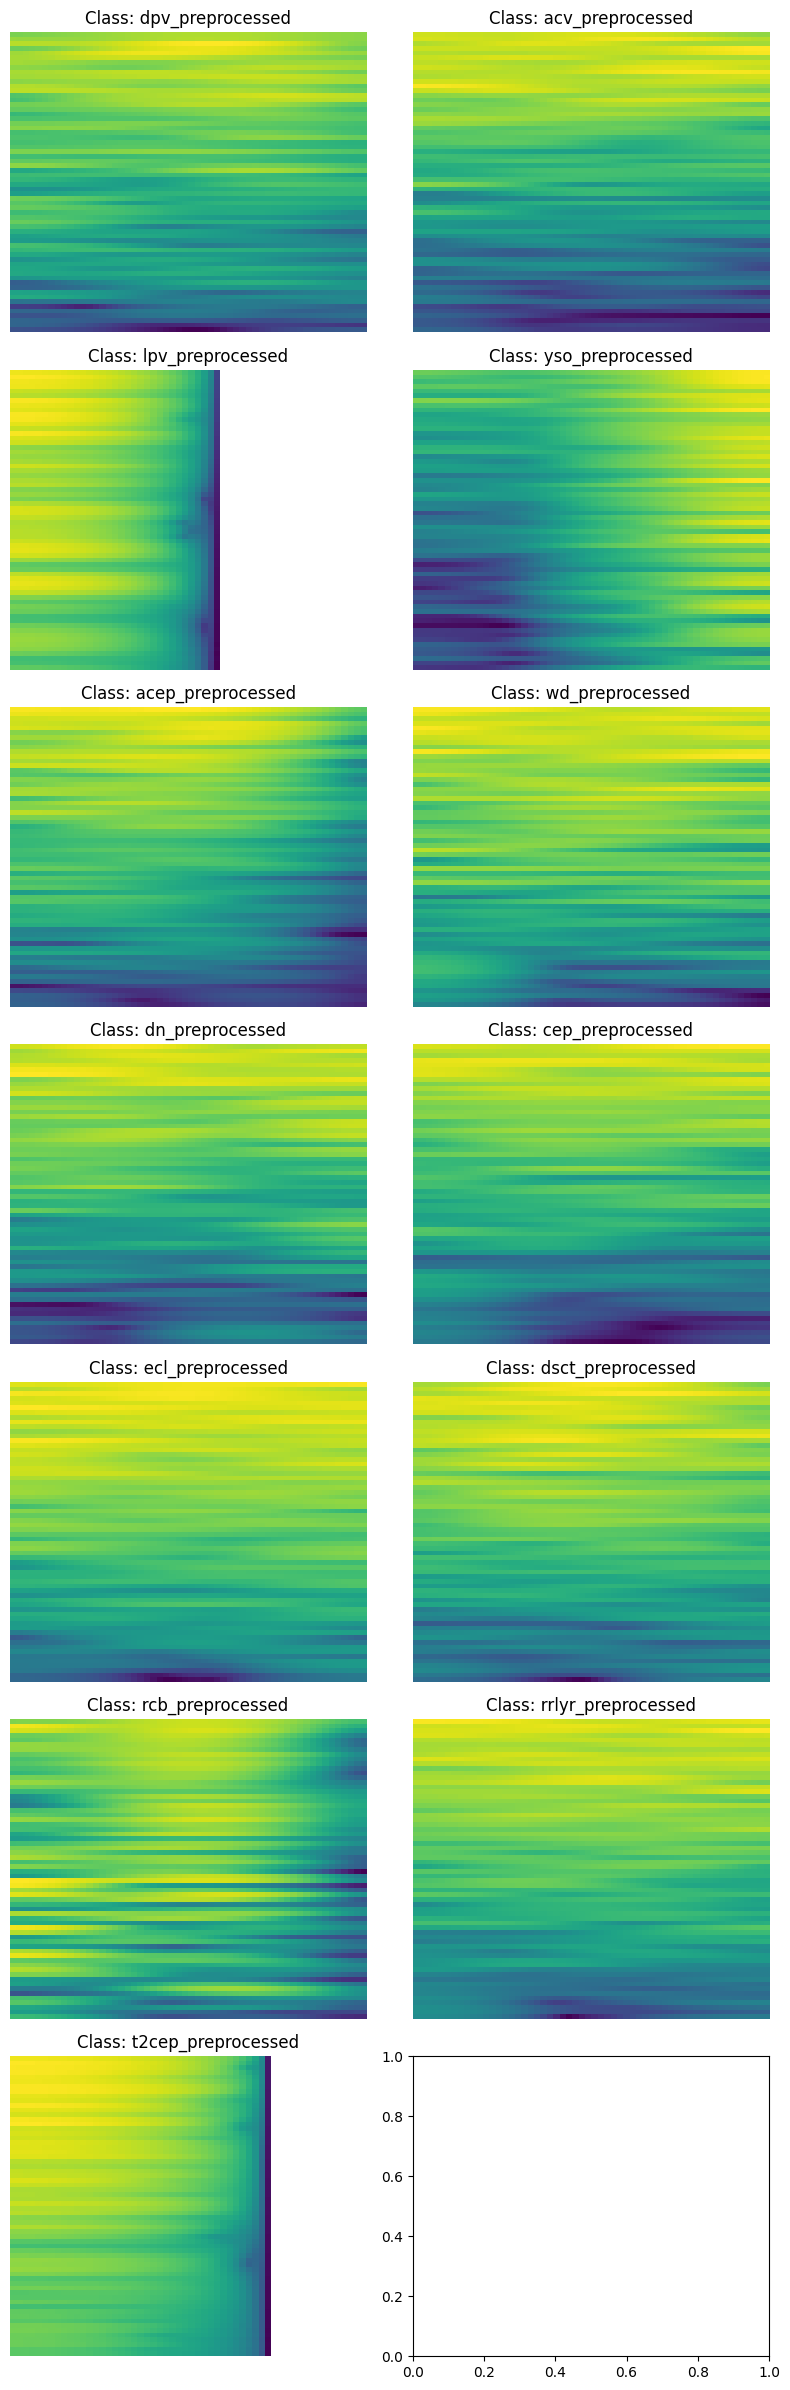

In [ ]:
plot_random_spectrograms(output_folder)

##create custom dataset and store them for fast computatution

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import torch
#import torchmetrics
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader,  SubsetRandomSampler,random_split
from torchvision import transforms
from tqdm import tqdm


In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on: {device}')

Training on: cpu


## custom spectrogramm dataset

In [ ]:
class OGLE3SpectrogramDataset(Dataset):
    def __init__(self, root_dir, min_files=200, load_from=None):
        """
        Initializes the dataset.
        Args:
            root_dir (str): Directory containing all the spectrogram files.
            min_files (int): Minimum number of files per class to be included in the dataset.
            load_from (str, optional): Path to load the dataset from if previously saved.
        """
        self.root_dir = root_dir
        self.min_files = min_files

        if load_from:
            self.data, self.labels = self.load_dataset(load_from)
        else:
            self.data, self.labels = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx < len(self.data):
            return {'data': self.data[idx], 'label': self.labels[idx]}
        else:
            return {'data': None, 'label': None}

    def load_data(self):
        data = []
        labels = []
        label_encoder = LabelEncoder()
        class_folders = [folder for folder in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, folder))]

        for folder in tqdm(class_folders, desc="Loading data"):
            class_path = os.path.join(self.root_dir, folder)
            files = [f for f in os.listdir(class_path) if f.endswith('.pt')]
            if len(files) >= self.min_files:
                class_label = folder.split('_')[0]
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    try:
                        spectrogram_tensor = torch.load(file_path)
                        data.append(spectrogram_tensor)
                        labels.append(class_label)
                    except Exception as e:
                        print(f"Error loading spectrogram {file_path}: {e}")

        if labels:
            labels = label_encoder.fit_transform(labels)
            labels = torch.tensor(labels, dtype=torch.long)

        return data, labels

    def save_dataset(self, save_path):
        torch.save({
            'data': self.data,
            'labels': self.labels
        }, save_path)

    @staticmethod
    def load_dataset(load_path):
        checkpoint = torch.load(load_path)
        data = checkpoint['data']
        labels = checkpoint['labels']
        return data, labels




In [ ]:
# Example usage:
root_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram_2'
save_path = '/content/drive/MyDrive/ADV_ML/saved_OGLE3_Spectrogram_2.pth'

In [ ]:
# Creating and saving the dataset
dataset = OGLE3SpectrogramDataset(root_folder)
dataset.save_dataset(save_path)

Loading data: 100%|██████████| 13/13 [29:12<00:00, 134.78s/it]


In [ ]:
# Loading the dataset
loaded_dataset = OGLE3SpectrogramDataset(root_folder, load_from=save_path)

## SAME custom dataset with augmentations

In [ ]:
def frequency_mask(spectrogram, max_mask_size=None):
    """ Apply a frequency mask to a spectrogram.
    Args:
        spectrogram (Tensor): Spectrogram to be masked.
        max_mask_size (int, optional): Maximum mask size. If None, use 10% of the frequencies.
    """
    num_frequencies = spectrogram.shape[0]
    max_mask_size = max_mask_size or int(0.1 * num_frequencies)
    mask_size = random.randint(1, max_mask_size)
    mask_start = random.randint(0, num_frequencies - mask_size)
    spectrogram[mask_start:mask_start + mask_size, :] = 0
    return spectrogram

def time_mask(spectrogram, max_mask_size=None):
    """ Apply a time mask to a spectrogram.
    Args:
        spectrogram (Tensor): Spectrogram to be masked.
        max_mask_size (int, optional): Maximum mask size. If None, use 10% of the time steps.
    """
    num_time_steps = spectrogram.shape[1]
    max_mask_size = max_mask_size or int(0.1 * num_time_steps)
    mask_size = random.randint(1, max_mask_size)
    mask_start = random.randint(0, num_time_steps - mask_size)
    spectrogram[:, mask_start:mask_start + mask_size] = 0
    return spectrogram

def add_gaussian_noise(spectrogram, mean=0, std=0.05):
    """ Add Gaussian noise to a spectrogram.
    Args:
        spectrogram (Tensor): Spectrogram to add noise to.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation of the Gaussian noise.
    """
    noise = torch.randn(spectrogram.shape) * std + mean
    return spectrogram + noise


In [ ]:
class OGLE3SpectrogramTransformedDataset(Dataset):
    def __init__(self, root_dir, min_files=200, load_from=None, transform=None):
        """
        Args:
            root_dir (str): Directory containing all the spectrogram files.
            min_files (int): Minimum number of files per class to be included in the dataset.
            load_from (str, optional): Path to load the dataset from if previously saved.
            transform (callable, optional): Transform to apply on each spectrogram.
        """
        self.root_dir = root_dir
        self.min_files = min_files
        self.transform = transform

        if load_from:
            self.data, self.labels = self.load_dataset(load_from)
        else:
            self.data, self.labels = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx < len(self.data):
          spectrogram, label = self.data[idx], self.labels[idx]
          if self.transform:
            spectrogram = self.transform(spectrogram)
            return {'data': spectrogram, 'label': label}
        else:
            return {'data': None, 'label': None}

    def load_data(self):
        data = []
        labels = []
        label_encoder = LabelEncoder()
        class_folders = [folder for folder in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, folder))]

        for folder in tqdm(class_folders, desc="Loading data"):
            class_path = os.path.join(self.root_dir, folder)
            files = [f for f in os.listdir(class_path) if f.endswith('.pt')]
            if len(files) >= self.min_files:
                class_label = folder.split('_')[0]
                for file_name in files:
                    file_path = os.path.join(class_path, file_name)
                    try:
                        spectrogram_tensor = torch.load(file_path)
                        data.append(spectrogram_tensor)
                        labels.append(class_label)
                    except Exception as e:
                        print(f"Error loading spectrogram {file_path}: {e}")

        if labels:
            labels = label_encoder.fit_transform(labels)
            labels = torch.tensor(labels, dtype=torch.long)

        return data, labels



    def save_dataset(self, save_path):
        torch.save({'data': self.data, 'labels': self.labels}, save_path)

    @staticmethod
    def load_dataset(load_path):
        checkpoint = torch.load(load_path)
        return checkpoint['data'], checkpoint['labels']





In [ ]:
# Define a transform that applies SpecAugment and Gaussian noise
def augment_spectrogram(spectrogram):
    spectrogram = frequency_mask(spectrogram)
    spectrogram = time_mask(spectrogram)
    spectrogram = add_gaussian_noise(spectrogram)
    return spectrogram


In [ ]:
root_folder = '/content/drive/MyDrive/ADV_ML/OGLE3_Spectrogram_2'
save_path = '/content/drive/MyDrive/ADV_ML/saved_OGLE3_Spectrogram_transformed.pth'



In [ ]:
# Creating and saving the dataset
dataset = OGLE3SpectrogramTransformedDataset(root_folder, transform=augment_spectrogram)
dataset.save_dataset(save_path)

# Loading the dataset
loaded_dataset = OGLE3SpectrogramTransformedDataset(root_folder, load_from=save_path, transform=augment_spectrogram)


Loading data: 100%|██████████| 13/13 [12:07<00:00, 55.96s/it]
